In [1]:
# Import the libraries.

import pandas as pd
import zipfile
import kaggle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats.api as sms
import scipy.stats as stats

In [2]:
# Download the dataset "Wine Reviews" from Kaggle, it will download a zip file.

!kaggle datasets download -d zhangluyuan/ab-testing

Dataset URL: https://www.kaggle.com/datasets/zhangluyuan/ab-testing
License(s): unknown
ab-testing.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Extract the content from the zip file.

zipfile_name = 'ab-testing.zip'
with zipfile.ZipFile(zipfile_name, 'r') as file:
    file.extractall()

In [4]:
# Read in the csv as a pandas dataframe.

df = pd.read_csv('ab_data.csv')

In [5]:
# Explore the data (part 1). 
# As far as we can see, the dataframe contains the following columns: user_id, timestamp, group, landing_page, converted.

df.sample(10)

,user_id,timestamp,group,landing_page,converted
238775,664098,2017-01-23 23:36:47.443678,treatment,new_page,0
22220,783134,2017-01-09 07:27:25.605993,control,old_page,1
36058,902115,2017-01-06 00:50:10.269596,control,old_page,0
105682,773321,2017-01-20 20:58:24.064193,treatment,new_page,0
176138,632748,2017-01-18 07:29:01.410143,treatment,new_page,0
89435,802656,2017-01-20 18:25:03.154497,control,old_page,0
238747,665003,2017-01-07 07:25:21.260358,control,old_page,1
242198,908736,2017-01-17 19:17:38.745277,control,old_page,0
156239,894340,2017-01-21 04:08:26.492242,control,old_page,0
81202,794505,2017-01-23 12:06:53.552206,treatment,new_page,1


In [6]:
# Explore shape of the dataframe: 294,478 rows and 5 columns.

df.shape

(294478, 5)

In [7]:
# The key insight of this code is that the number of rows (294,478) is greater than the number of unique users (290,584). That means some users appear more than once.
# In an A/B test, each user should only be in one group, so duplicate users can bias the results.

df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [8]:
# There's no null values.

df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [9]:
# The next it's the information of the whole dataframe.
# The content of the 5 columns are the following:
# 'user_id' contains user ids
# 'timestamp' is about when a session was
# 'group' contains 2 variables: control and treatment
# 'landing_page' is about what version of a site a user saw
# 'converted' says us about user's behavior: if a user made a purchase (1) or not (0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
# The following code shows some mismatches; control group should only the old page and treatment group should only see the new page.

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [11]:
# Align groups to their specific landing pages.

df_clean = df[
    ((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))
]

In [12]:
# Validate the groups are correctly align.

pd.crosstab(df_clean['group'], df_clean['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


In [13]:
# Considering that the company has a conversion rate (number of purchases/number of visits) of 11% and we want to increase it to 13%,
# we need 5,539 users in control and 5,539 users in treatment group.

effect_size = sms.proportion_effectsize(0.11, 0.13)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.9,  #power of a test (defualt is 0.8)
    alpha=0.05, #p-value
    ratio=1
    )                                                  # Calculating sample size needed

required_n = round(required_n)                          # Rounding up to next whole number                          

print(required_n)

5539


In [14]:
# Align groups helped with the duplicates, despite there's just one another duplicate.

df_clean[['user_id','timestamp']].nunique()

user_id      290584
timestamp    290585
dtype: int64

In [15]:
# The one that has more that one occurance it is the duplicated one.

df_clean.user_id.value_counts()

user_id
773192    2
851104    1
688307    1
718297    1
838144    1
         ..
755610    1
804629    1
837875    1
889019    1
715931    1
Name: count, Length: 290584, dtype: int64

In [16]:
# Get the index of the duplicate. 

session_counts = df_clean.user_id.value_counts()
double_users = session_counts[session_counts>1].index

double_users

Index([773192], dtype='int64', name='user_id')

In [17]:
# Remove the duplicate.

df_clean = df_clean[~df_clean['user_id'].isin(double_users)]
df_clean.shape

(290583, 5)

In [18]:
# Create the samples of each group.

control_group = df.query('group == "control"').sample(required_n)
treatment_group = df.query('group == "treatment"').sample(required_n)

In [19]:
# Control group.

control_group.head()

,user_id,timestamp,group,landing_page,converted
215655,778281,2017-01-22 23:10:21.440631,control,old_page,0
100597,728229,2017-01-18 22:40:15.351221,control,old_page,0
105849,906831,2017-01-11 20:08:36.630734,control,old_page,1
177762,870756,2017-01-19 04:57:06.533906,control,old_page,0
198192,848742,2017-01-20 23:29:05.457594,control,old_page,0


In [20]:
# Treatment group.

treatment_group.head()

,user_id,timestamp,group,landing_page,converted
136200,765081,2017-01-05 12:24:25.337718,treatment,new_page,0
133978,797388,2017-01-15 16:51:43.217936,treatment,new_page,0
257411,888150,2017-01-07 12:56:36.476913,treatment,new_page,0
274724,814802,2017-01-08 09:23:19.977893,treatment,new_page,1
61509,811949,2017-01-07 07:02:17.581410,treatment,new_page,0


In [21]:
# Concat two groups.

ab_test = pd.concat([control_group, treatment_group], axis=0)
ab_test.reset_index(inplace=True, drop=True)

In [22]:
# View of the df ab_test.

ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,778281,2017-01-22 23:10:21.440631,control,old_page,0
1,728229,2017-01-18 22:40:15.351221,control,old_page,0
2,906831,2017-01-11 20:08:36.630734,control,old_page,1
3,870756,2017-01-19 04:57:06.533906,control,old_page,0
4,848742,2017-01-20 23:29:05.457594,control,old_page,0


In [23]:
# Info of the df ab_test.

ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11078 entries, 0 to 11077
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       11078 non-null  int64 
 1   timestamp     11078 non-null  object
 2   group         11078 non-null  object
 3   landing_page  11078 non-null  object
 4   converted     11078 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 432.9+ KB


In [24]:
# Validate the required number of samples for each group.

ab_test.group.value_counts()

group
control      5539
treatment    5539
Name: count, dtype: int64

In [25]:
# The control group shows 11.9% conversion rate and the treatment group 12.1% conversion rate.

conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=1)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=1)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

/var/folders/_4/yjfxm4z91c16k9w6fph_q_2w0000gn/T/ipykernel_92601/2693458454.py:8: FutureWarning: The provided callable <function mean at 0x103de7420> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])


,conversion_rate,std_deviation,std_error
group,,,
control,0.122,0.327,0.004
treatment,0.125,0.330,0.004


In [26]:
# Count the number of occurrences of each group.

total_counts = ab_test.groupby('group')['converted'].count()
print(total_counts)

group
control      5539
treatment    5539
Name: converted, dtype: int64


In [27]:
# Count the number of users converted (1) with method sum.

conversion_counts = ab_test.groupby('group')['converted'].sum()
print(conversion_counts)

group
control      676
treatment    690
Name: converted, dtype: int64


In [28]:
# Interpretation:
# The p-value of 0.7702 is greater than the significance level of 0.05,
# so we fail to reject the null hypothesis. This suggests that the
# observed difference in conversion rates between groups A and B is not statistically significant, which in Z-statistic we can see that are not so different between
# each other, let's no forget that 0 means that two groups are identical, -0.29 means the treatment group it's just 0.29 standard deviations less than control, a tiny difference.

z_stat, p_val = proportions_ztest(count=conversion_counts.values, nobs=total_counts.values)
print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_val:.4f}")

Z-statistic: -0.405
P-value: 0.6858


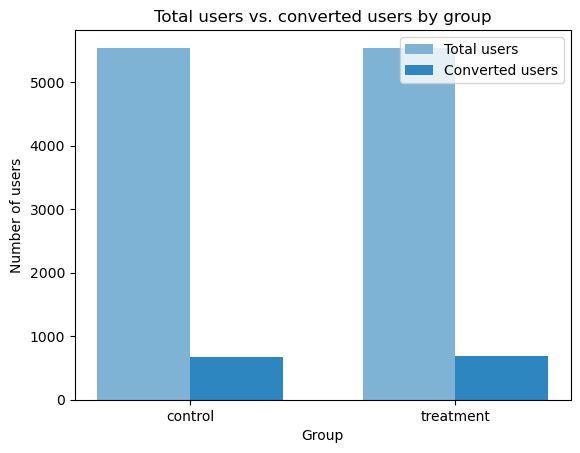

In [29]:
# Count users per group.

group_counts = ab_test['group'].value_counts().sort_index()
conversion_counts = ab_test[ab_test['converted'] == 1]['group'].value_counts().sort_index()

# Creat positions in X axis per bar.

x = np.arange(len(group_counts))  # [0, 1] for A and B groups
width = 0.35  # Width for each bar

# Graph bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, group_counts.values, width, label='Total users', color='#7FB3D5')     
bars2 = ax.bar(x + width/2, conversion_counts.values, width, label='Converted users', color='#2E86C1')  

# Labels and ticks

ax.set_xticks(x)
ax.set_xticklabels(group_counts.index)
ax.set_xlabel('Group')
ax.set_ylabel('Number of users')
ax.set_title('Total users vs. converted users by group')
ax.legend()

plt.show()